In [33]:
# работа с таблицами
import numpy as np
import pandas as pd

# импорт данных
import json

# отображение текстовых данных по ширине окна
import textwrap

# проверка на наличие эмодзи
import emoji

# очистка текста
import re
import string

# лемматизация
import pymorphy3

# векторизация текста
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV
# метрики
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import time

import matplotlib.pyplot as plt

import mplcyberpunk

plt.style.use("cyberpunk")

import pickle

In [2]:
df = pd.read_feather("/home/artemiy/nlp_project/data/tg_channels.feather")

In [3]:
df.head()

,url,date,content,label
0,https://t.me/s/russianmoda/5961,2023-09-17 17:09:06+00:00,Широкие бедра всегда считались роскошью и прид...,мода
1,https://t.me/s/russianmoda/5957,2023-09-17 12:09:06+00:00,"Не знаю как у вас, но у меня ни одна осень не ...",мода
2,https://t.me/s/russianmoda/5951,2023-09-17 06:09:06+00:00,Осенью настроение немножко ухудшается. Этому с...,мода
3,https://t.me/s/russianmoda/5939,2023-09-16 17:09:06+00:00,"Кардиган очень коварен в стилизации, поэтому е...",мода
4,https://t.me/s/russianmoda/5935,2023-09-16 12:09:06+00:00,Трикотажные костюмы часто ассоциируются с брюк...,мода


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype              
---  ------   --------------  -----              
 0   url      2900 non-null   object             
 1   date     2900 non-null   datetime64[ns, UTC]
 2   content  2852 non-null   object             
 3   label    2900 non-null   object             
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 90.8+ KB


In [5]:
df["label"].value_counts()

label
мода          600
технологии    600
финансы       600
крипта        600
спорт         500
Name: count, dtype: int64

In [6]:
df.dropna(subset=["content"], inplace=True)

In [7]:
df.isna().sum()

url        0
date       0
content    0
label      0
dtype: int64

(array([598.,   0., 499.,   0.,   0., 589.,   0., 583.,   0., 583.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

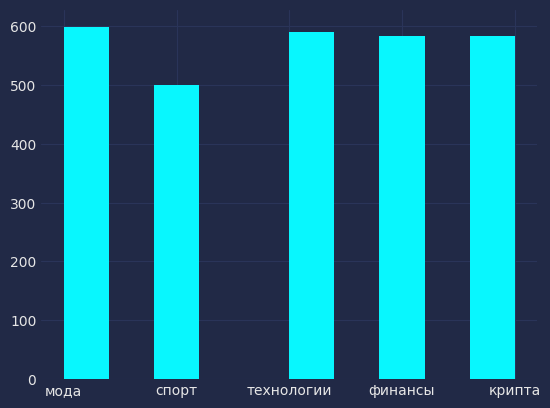

In [8]:
plt.hist(df["label"])

In [9]:
print(textwrap.fill(df["content"][1500]))

💸Пользоваться Binance из-за границы россиянам все ещё можно. Но не с
рублем.Binance официально подтвердил ограничения для граждан РФ.
Торговать россиянам можно только с рублем, а торговать рублем можно
только россиянам. Ограничения не полностью распространяются на
релокантов: если живете больше полугода в другой стране, торговать
можно чем угодно, кроме рубля, евро и доллара. 😿Резюме: Если
зарабатываете в России, и живете в другой стране, нужно придумывать
новые способы выводить деньги. Или переходить на зп в другой валюте.


In [10]:
with open(
    "/home/artemiy/nlp_project/data/stopwords-ru.txt", "r", encoding="utf-8"
) as file:
    stop_words = set(file.read().split())

In [11]:
emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # Emoticons
    "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
    "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
    "\U0001F1E0-\U0001F1FF"  # Flags (iOS)
    "\U00002700-\U000027BF"  # Dingbats
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U00002600-\U000026FF"  # Miscellaneous Symbols
    "\U00002B50-\U00002B55"  # Miscellaneous Symbols and Pictographs
    "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    "\U0001F700-\U0001F77F"  # Alchemical Symbols
    "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"  # Chess Symbols
    "]+",
    flags=re.UNICODE,
)

In [12]:
def has_emoji(text):
    if emoji_pattern.search(text):
        return "эмодзи детектед"
            
    else:
        return "эмодзи не обнаружен"

In [13]:
emoji_detection_results = df["content"].apply(has_emoji)

# Подсчет количества строк с эмодзи
emoji_detected_count = (emoji_detection_results == "эмодзи детектед").sum()
print(emoji_detected_count)

1683


In [14]:
def clean(text, stop__words):
    text = text.lower()  # нижний регистр
    text = re.sub(r"http\S+", " ", text)  # удаляем ссылки
    text = re.sub(r"@\w+", " ", text)  # удаляем упоминания пользователей
    text = re.sub(r"#\w+", " ", text)  # удаляем хэштеги
    text = re.sub(r"\d+", " ", text)  # удаляем числа
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"<.*?>", " ", text)  #
    text = re.sub(r"[️«»—]", " ", text)
    text = re.sub(r"[^а-яё ]", " ", text)
    text = text.lower()
    text = emoji_pattern.sub(r"", text)
    text = " ".join([word for word in text.split() if word not in stop__words])
    return text

In [15]:
clean_text = [clean(text, stop_words) for text in df["content"]]

In [16]:
print(textwrap.fill(clean_text[1458]))

рассказали презентации максимально кратко размеры аппаратов остались
прежними вес снизился грамм цены сша изменились эра наступила
заряжаются стандартной зарядкой требуют законы ес скорость передачи
данных составляет гбитсек добавили динамический остров вместо челки
писал убрали легендарную кнопку беззвучного режима моделей вместо
появилась которую повесить дополнительные функции включение крепилось
процессор презентации показали консольные игры запустились нормальным
смартфонах камера получила разрешение мегапикселей способна снимки
модели научились снимать видео идее гарнитуры накопили тысячи долларов
убрали линейки видимо окончательно ии упомянули нейросети внедрили
камеру авто включения портретного режима точку фокусировки изменить
снимка нечего экран ярче автономная дольше добавился необычный розовый
цвет управление жестами предыдущих моделях компания сделала акцент
экоследе кожи ремешках коробки стали новые стали углероднонейтральными
стабильность признак мастерства


In [17]:
morph = pymorphy3.MorphAnalyzer()

In [18]:
def lemmatize(text):
    words = text.split()
    lem_words = [morph.parse(word)[0].normal_form for word in words]
    return " ".join(lem_words)

In [19]:
lem_text = [lemmatize(text) for text in clean_text]

In [21]:
print(textwrap.fill(lem_text[1458]))

рассказать презентация максимально кратко размер аппарат остаться
прежний вес снизиться грамм цена сша измениться эра наступить
заряжаться стандартный зарядка требовать закон ес скорость передача
данные составлять гбитсек добавить динамический остров вместо чёлка
писать убрать легендарный кнопка беззвучный режим модель вместо
появиться который повесить дополнительный функция включение крепиться
процессор презентация показать консольный игра запуститься нормальный
смартфон камера получить разрешение мегапиксель способный снимок
модель научиться снимать видео идея гарнитур накопить тысяча доллар
убрать линейка видимо окончательно ия упомянуть нейросеть внедрить
камера авто включение портретный режим точка фокусировка изменить
снимок нечего экран яркий автономный долгий добавиться необычный
розовый цвет управление жест предыдущий модель компания сделать акцент
экослед кожа ремешок коробка стать новый стать углероднонейтральный
стабильность признак мастерство


In [22]:
vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    ngram_range=(1,3)
)

X_tfidf = vectorizer.fit_transform(lem_text)

In [23]:
print(f"Shape of TF-IDF matrix: {X_tfidf.shape}")

Shape of TF-IDF matrix: (2852, 5185)


In [27]:
y = df['label'].values
y

array(['мода', 'мода', 'мода', ..., 'крипта', 'крипта', 'крипта'],
      dtype=object)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

In [34]:
# поиск потимальных параметров
# для логрег
param_grid_logreg = {
    "C": [0.01, 0.1, 1, 10, 100],
    "solver": ["liblinear", "lbfgs", "saga"],
}
# Для SVM
param_grid_svm = {
    "C": [0.01, 0.1, 1, 10, 100],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", 0.01, 0.1, 1, 10],
}
# Для Random Forest
param_grid_forest = {
    "n_estimators": [100, 200, 500, 1000],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

In [36]:
grid_logreg = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_logreg, cv=5)
grid_logreg.fit(X_train, y_train)
grid_svm = GridSearchCV(svm.SVC(), param_grid_svm, cv=5)
grid_svm.fit(X_train, y_train)
grid_forest = GridSearchCV(
    RandomForestClassifier(random_state=42), param_grid_forest, cv=5
)
grid_forest.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500, 1000]})

In [37]:
print("Лучшие параметры для логистической регрессии:", grid_logreg.best_params_)
print("Лучшие параметры для SVM:", grid_svm.best_params_)
print("Лучшие параметры для Random Forest:", grid_forest.best_params_)

Лучшие параметры для логистической регрессии: {'C': 10, 'solver': 'liblinear'}
Лучшие параметры для SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Лучшие параметры для Random Forest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 1000}


In [38]:
logreg = LogisticRegression(**grid_logreg.best_params_, max_iter=1000)
vectors = svm.SVC(**grid_svm.best_params_)
forest = RandomForestClassifier(**grid_forest.best_params_)

In [39]:
logreg.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000, solver='liblinear')

In [40]:
vectors.fit(X_train, y_train)

SVC(C=10)

In [41]:
forest.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=10,
                       n_estimators=1000)

In [42]:
logreg_pred = logreg.predict(X_test)
vectors_pred = vectors.predict(X_test)
forest_pred = forest.predict(X_test)

# Метрики

In [43]:
# Вывод метрик для логистической регрессии
logreg_accuracy = accuracy_score(y_test, logreg_pred)
logreg_f1 = f1_score(y_test, logreg_pred, average="weighted")
print(f"Logistic Regression Accuracy: {logreg_accuracy:.4f}")
print(f"Logistic Regression F1 Score: {logreg_f1:.4f}")

# Вывод метрик для SVM
vectors_accuracy = accuracy_score(y_test, vectors_pred)
vectors_f1 = f1_score(y_test, vectors_pred, average="weighted")
print(f"SVM Accuracy: {vectors_accuracy:.4f}")
print(f"SVM F1 Score: {vectors_f1:.4f}")

# Вывод метрик для Random Forest
forest_accuracy = accuracy_score(y_test, forest_pred)
forest_f1 = f1_score(y_test, forest_pred, average="weighted")
print(f"Random Forest Accuracy: {forest_accuracy:.4f}")
print(f"Random Forest F1 Score: {forest_f1:.4f}")

Logistic Regression Accuracy: 0.9002
Logistic Regression F1 Score: 0.9006
SVM Accuracy: 0.9019
SVM F1 Score: 0.9027
Random Forest Accuracy: 0.8459
Random Forest F1 Score: 0.8474


In [44]:
categories_dict = {0: "мода",
                1: "технологии", 
                2: "финансы", 
                3: "крипта", 
                4: "спорт"}

In [90]:
# Функция предсказания категории по тексту
def predict_category(text):
    # Очистка и лемматизация текста (подставьте свои функции clean и lemmatize)
    clean_text = clean(text, stop_words)
    lem_text = lemmatize(clean_text)

    # Преобразование текста в TF-IDF представление
    X_new = vectorizer.transform([lem_text])

    # Предсказание категории
    prediction = vectors.predict(X_new)[0]
    # print(prediction)

    # # Получение категории из словаря
    # if prediction not in categories_dict:
    #     category = "Ошибка предсказания"
    # else:
    #     category = categories_dict[prediction]

    return prediction

In [51]:
# # Сохранение модели в файл
# with open("logregmodel_tg.pkl", "wb") as file:
#     pickle.dump(logreg, file)
# # Сохранение модели в файл
# with open("vectorsmodel_tg.pkl", "wb") as file:
#     pickle.dump(vectors, file)
# # Сохранение модели в файл
# with open("forestmodel_tg.pkl", "wb") as file:
#     pickle.dump(forest, file)

In [98]:
# Сохранение TfidfVectorizer в файл с помощью pickle
# with open("tfidf_vectorizer_tg.pkl", "wb") as f:
#     pickle.dump(vectorizer, f)

In [103]:
# Пример использования функции predict_category
message = "я вчера пошел гулять и нашел айфон"
predicted_category = predict_category(message)
print(f"Предсказанная категория: {predicted_category}")

Предсказанная категория: мода


In [107]:
df['content'][1775]

'О качестве прогнозов ведущих мировых институтов.Bloomberg Economics теперь прогнозирует, что ВВП Китая не превысит ВВП США до середины 2040-х годов, а затем начнёт отставать. До пандемии Bloomberg прогнозировал, что к началу 2030-х годов Китай окончательно обгонит США.Так что российские горе-прогнозисты (например, предвещающие на протяжении последних лет скорый крах доллара) смотрятся уже не так плохо на фоне прогнозов Bloomberg.Почему Bloomberg Economics изменил прогноз? Они предполагают, что рост экономики Китая замедлится до 3,5% к 2030 году и до 1% к 2050 году. Это ниже, чем предыдущие прогнозы в 4,3% и 1,6% соответственно.Но некоторые радикальные экономисты в США критикуют и этот прогноз Bloomberg – почему они уверены, что единый Китай сохранится к 2050 году? В своё время ЦРУ также строило прогнозы, что СССР к 2000 году приблизится к США по большинству макропоказателей.'